In [56]:
import requests 
import json
from pprint import pprint
import os
import pandas as pd
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import gmaps
from scipy.stats import sem
from scipy.stats import linregress
from config import Q1api_key
from config import Q1_GKey

In [57]:
# # Import Merged GDP and Weather data
merge_path = os.path.join("Resources", "Merge_data_2005-2015.csv")
merge_df = pd.read_csv(merge_path)

merge_df.head()

,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087


In [58]:
# # Understand the data
max_Rain = merge_df['Rainfall_mm'].max()
min_Rain = merge_df['Rainfall_mm'].min()
print(f"Maximum temperature in data is {max_Rain}")
print(f"Minimum temperature in data is {min_Rain}")

max_GDP = merge_df['GDP_bd'].max()
min_GDP = merge_df['GDP_bd'].min()
print(f"Maximum Gross Domestic Product in data is {max_GDP}")
print(f"Minimum Gross Domestic Product in data is {min_GDP}")

Maximum temperature in data is 736.4781750000002
Minimum temperature in data is 1.6598875000000002
Maximum Gross Domestic Product in data is 18219.3
Minimum Gross Domestic Product in data is 0.02183909889


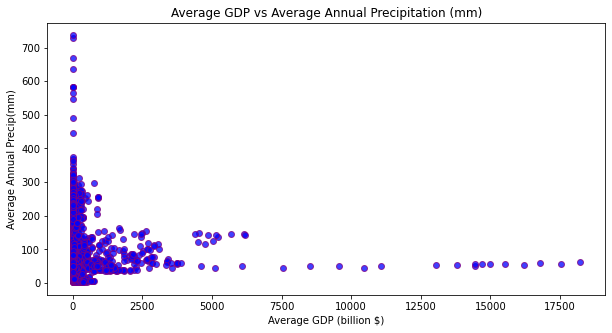

<Figure size 432x288 with 0 Axes>

In [60]:
# # Plot all the data
# Plot the Rainfall versus GDP data to look for trend/features to investigate
ListofISO34Plot = merge_df['ISO3']
# # Make Scatter plot of Rainfall vs GDP  
plt.figure(figsize=(10,5))
plt.scatter(merge_df["GDP_bd"], merge_df["Rainfall_mm"], marker='o', facecolor='b', edgecolors='purple', alpha = 0.75)
plt.title(f"Average GDP vs Average Annual Precipitation (mm)")
plt.xlabel("Average GDP (billion $)")
plt.ylabel("Average Annual Precip(mm)")
plt.show()
plt.savefig(f"output_data/Q2/Fig1x_AvTemp_vs_GDP_AllCountries")



In [ ]:
# Crop data to area of interest
zone1_df = merge_df.loc[(merge_df['Rainfall_mm']>=150) & (merge_df['Rainfall_mm']<=250)]
zone1_df

zone2_df = merge_df.loc[(merge_df['Rainfall_mm']>=50) & (merge_df['Rainfall_mm']<=149)]
zone2_df

zone3_df = merge_df.loc[(merge_df['Rainfall_mm']> 0) & (merge_df['Rainfall_mm']<=49)]
zone3_df

# Create a merged (zone1, 2 & 3) dataframe
ZONE_df = merge_df.loc[(merge_df['Rainfall_mm']>=150) & (merge_df['Rainfall_mm']<=250) | (merge_df['Rainfall_mm']>=50) & (merge_df['Rainfall_mm']<=149) | (merge_df['Rainfall_mm']> 0) & (merge_df['Rainfall_mm']<=49)]
ZONE_df = ZONE_df.dropna(how='any')


# # Understand the data
ZoneCountries = ZONE_df['ISO3'].nunique()
print(f"No. of countries after filter {ZoneCountries}")

ZONE_df

In [38]:
# # Looking for Regressions
# Looking at the trend line for temperature over time (10yrs) for each country and GDP over time for 
# the same country storing these values to compare them.

# FOR COMBINED ZONES OF INTEREST
ListofISO3_Merged = ZONE_df['ISO3']
ZONERegressList = []
ZONERegressDictGDP = {}
ZONERegressDictRain = {}
R_ValuesGDP = {}
R_ValuesRain = {}

# Run for loop to get regression values for GDP for each country
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = ZONE_df.loc[ZONE_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Rain = ZONECorrelation_df['Rainfall_mm']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, GDP)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    ZONERegressDictGDP[ISO] = Zone_Rvalue
R_ValuesGDP = ZONERegressDictGDP

# Run for loop to get regression values for annual average Temperature for each country
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = ZONE_df.loc[ZONE_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Rain = ZONECorrelation_df['Rainfall_mm']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, Rain)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    ZONERegressDictRain[ISO] = Zone_Rvalue
R_ValuesRain = ZONERegressDictRain


In [50]:
# # Comparing GDP and Temperature regressions
# Looking at the difference between the r-value for the GDP trend line and the annual temperature of a given 
# country would help ascertain any relationship.
# For example, a high, positive r-value for the GDP trend line and a smiliar high, positive r-value for the 
# annual temperature trend line indicates the possibility of a correlation.

# Create a df to look at the GDP and Temperature regressions
RegressList ={"RAIN_REGRESS": R_ValuesRain,"GDP_REGRESS": R_ValuesGDP}
Regress_df = pd.DataFrame(RegressList)
Regress_df = Regress_df.reset_index()
Regress_df = Regress_df.rename(columns={'index': 'ISO3'})
Regress_df['Regression_diff'] = Regress_df['RAIN_REGRESS'] - Regress_df['GDP_REGRESS']
Regress_df = Regress_df.sort_values(by='Regression_diff', ascending=True)
Regress_df.tail(50)

,ISO3,RAIN_REGRESS,GDP_REGRESS,Regression_diff
171,TUR,0.293114,0.914206,-0.621093
175,UKR,-0.363152,0.249320,-0.612472
88,KEN,0.380956,0.988541,-0.607584
149,SLE,0.331116,0.927445,-0.596329
164,TJK,0.373637,0.967320,-0.593683
122,NZL,0.351926,0.921504,-0.569579
112,MEX,0.265882,0.827241,-0.561360
180,UZB,0.435565,0.993627,-0.558062
115,MNG,0.397713,0.946045,-0.548331
117,MOZ,0.390419,0.935982,-0.545563


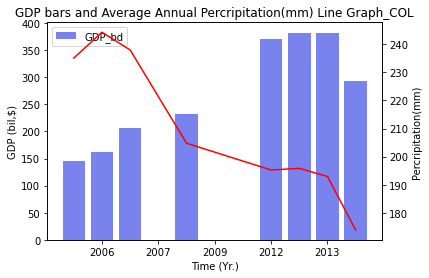

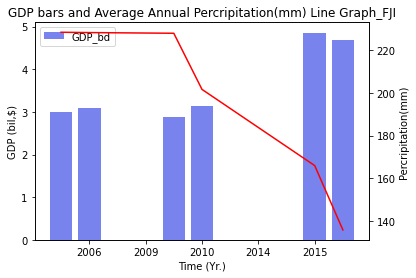

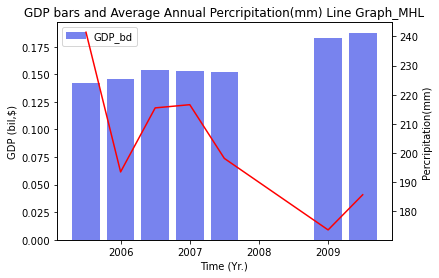

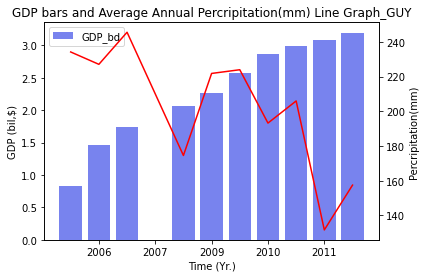

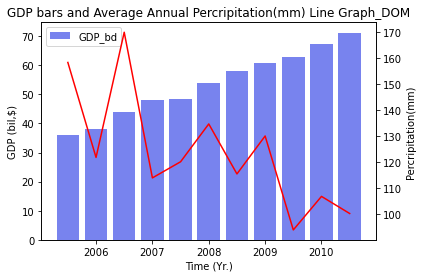

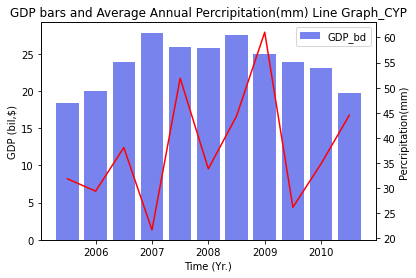

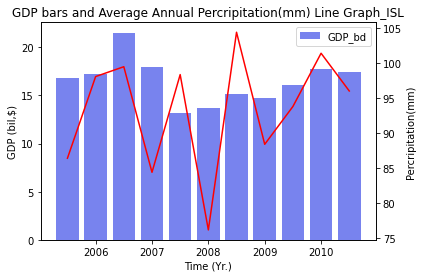

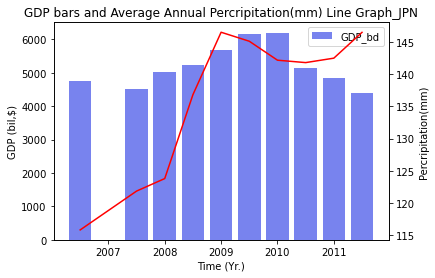

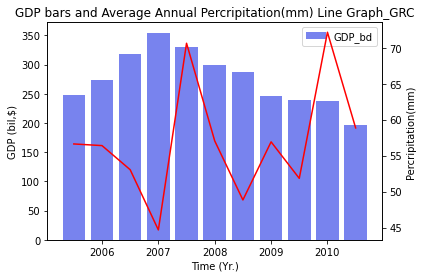

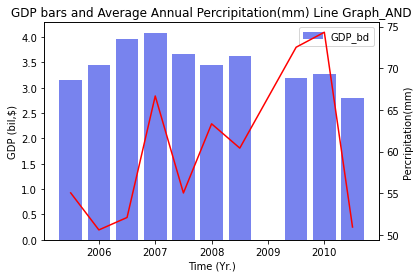

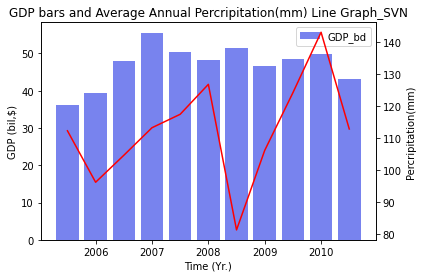

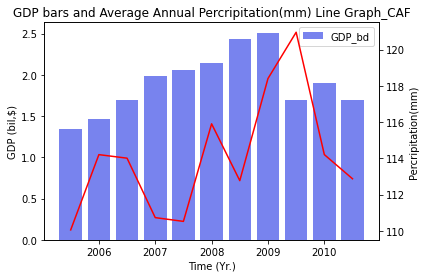

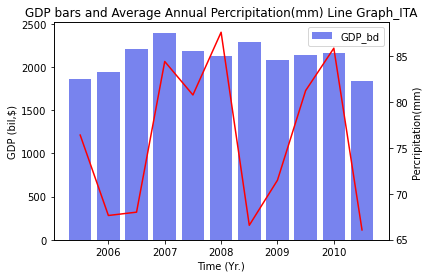

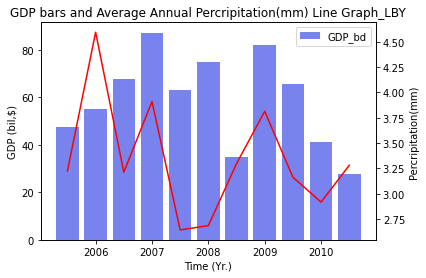

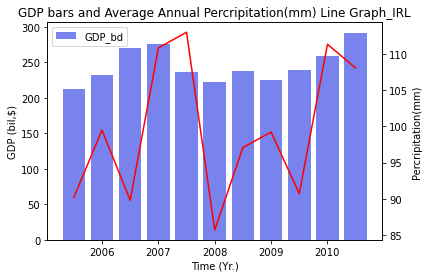

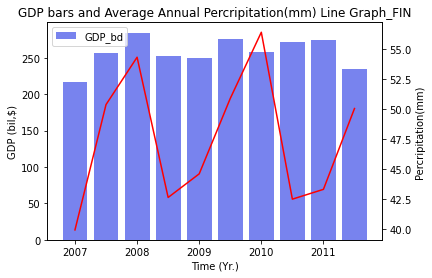

In [52]:
# # Dual axis bar/line chart
# A bar chart/ line graph to compare GDP and annual temperature trends over time.
# Make a ISO List based on findings from regress data frame
RegressList = ['COL', 'FJI', 'MHL', 'GUY', 'DOM', 'CYP', 'ISL', 'JPN', 'GRC', 'AND', 'SVN', 'CAF', 'ITA', 'LBY', 'IRL', 'FIN']
for ISO in RegressList:
    BarGraph_df = ZONE_df.loc[ZONE_df['ISO3']== ISO]
    yearList = BarGraph_df['Year'].unique()
    yearNo = np.array(range(len(yearList)))
    GDPNos = BarGraph_df['GDP_bd']
    RainNos = BarGraph_df['Rainfall_mm']
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(yearList, GDPNos, color=(63/255,79/255,232/255,0.7), label='GDP_bd')
    ax2.plot(yearList, RainNos, color='red', label='Precripitation(mm)')
    ax.set_xticklabels(yearList)
    ax.legend(loc='best')
    ax.set_title(f"GDP bars and Average Annual Precripitation(mm) Line Graph_{ISO}")
    ax.set_ylabel('GDP (bil,$)')
    ax2.set_ylabel('Precripitation(mm)')
    ax.set_xlabel('Time (Yr.)')
    plt.savefig(f"output_data/Q2/Fig2_GDP_BarChart_RainLineChart_{ISO}_2005-2015.png")


In [36]:
# # Lat long of capital cities of correlated countries
# # CorrCountriesList = []
# BGD = (23.763889, 90.388889)
# TUV = (-8.516667, 179.2)
# AND = (42.5, 1.516667)
# MNP = (15.19, 145.74)
# ALB = (41.316667, 19.816667)
# ROU = (44.416667, 26.1)

# CorrCountriesList = [BGD,TUV, AND, MNP, ALB, ROU]

In [37]:
# # CREATE A GEOXXXX MAP
# # STEP 1 ---------------------------------------------------------
# # SET UP LAT LONG PAIRS
# Coords = CorrCountriesList
# Coords

# fig = gmaps.figure()

# # Create a marker layer using our coordinates
# markers = gmaps.marker_layer(Coords)

# # Add the layer to the map
# fig.add_layer(markers)

# # display the figure with the newly added layer
# fig



Figure(layout=FigureLayout(height='420px'))